<a href="https://colab.research.google.com/github/YoojLee/d2dl/blob/week4/7_Modern_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7. Modern CNNs

## 7.1. AlexNet

### 7.1.2. AlexNet Structure

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=.5),
    nn.Linear(4096,10)
)

In [3]:
X = torch.randn(1,1,224,224)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### 7.1.3. Reading the Dataset

In [6]:
batch_size=64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

### 7.1.4. Training

In [7]:
lr, num_epochs = .01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## 7.2. Networks Using Blocks (VGG)

### 7.2.1. VGG Blocks

In [10]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

### 7.2.2. VGG Network

In [11]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [13]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1

    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096,10)
    )

net = vgg(conv_arch)

In [14]:
X = torch.randn((1,1,224,224))

for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape: \t', X.shape)

Sequential output shape: 	 torch.Size([1, 64, 112, 112])
Sequential output shape: 	 torch.Size([1, 128, 56, 56])
Sequential output shape: 	 torch.Size([1, 256, 28, 28])
Sequential output shape: 	 torch.Size([1, 512, 14, 14])
Sequential output shape: 	 torch.Size([1, 512, 7, 7])
Flatten output shape: 	 torch.Size([1, 25088])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 10])


### 7.2.3. Training

In [15]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.173, train acc 0.936, test acc 0.915
340.2 examples/sec on cuda:0


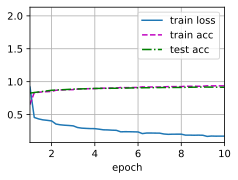

In [16]:
lr, num_epochs, batch_size = 0.05, 10, 128

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 7.3. Network in Network (NiN)

### 7.3.1. NiN Blocks

In [19]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

### 7.3.2. NiN Model

In [20]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
    )

In [21]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


### 7.3.3. Training

loss 0.385, train acc 0.858, test acc 0.860
378.7 examples/sec on cuda:0


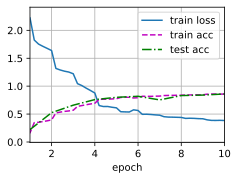

In [22]:
lr = 0.1
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.4. Networks with Parallel Concatenations (GoogLeNet)

### 7.4.1. Inception Blocks

In [23]:
from torch.nn import functional as F

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))

        return torch.cat((p1, p2, p3, p4), dim=1)

In [24]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )

In [25]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(64, 192, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                )

In [26]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                    Inception(256, 128, (128, 192), (32, 96), 64),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )

In [27]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                    Inception(512, 160, (112, 224), (24, 64), 64),
                    Inception(512, 128, (128, 256), (24, 64), 64),
                    Inception(512, 112, (144, 288), (32, 64), 64),
                    Inception(528, 256, (160, 320), (32, 128), 128),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )

In [28]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                    Inception(832, 384, (192, 384), (48, 128), 128),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [29]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.250, train acc 0.905, test acc 0.885
395.0 examples/sec on cuda:0


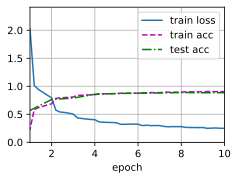

In [30]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())